In [6]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_fscore_support
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import gymnasium as gym
import d3rlpy
import warnings

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/Users/pushkarjain/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
warnings.filterwarnings("ignore")


DATA_PATH = "accepted_2007_to_2018Q4.csv"  
SAMPLE_FRAC = 0.05  
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


print("Loading data (this can be slow for full dataset)...")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Place 'accepted_2007_to_2018.csv' at {DATA_PATH}")


usecols = [
    'loan_amnt', 'int_rate', 'term', 'installment', 'grade', 'sub_grade',
    'emp_title','emp_length','home_ownership','annual_inc','verification_status',
    'purpose','title','zip_code','addr_state','dti','delinq_2yrs','fico_range_low','fico_range_high',
    'open_acc','revol_bal','revol_util','total_acc','application_type','loan_status'
]
df = pd.read_csv(DATA_PATH, usecols=usecols, low_memory=False)
print("Initial rows:", len(df))

if SAMPLE_FRAC is not None and 0 < SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED).reset_index(drop=True)
    print("Sampled rows:", len(df))

Loading data (this can be slow for full dataset)...
Initial rows: 2260701
Sampled rows: 113035


In [8]:

print("\nEDA & target mapping...")
print(df.loan_status.value_counts(dropna=False).head(20))

keep_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(keep_status)].copy()
df['target'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
print("After keeping Fully Paid and Charged Off -- rows:", len(df))
print(df.target.value_counts())


EDA & target mapping...
loan_status
Fully Paid                                             53601
Current                                                43987
Charged Off                                            13616
Late (31-120 days)                                      1082
In Grace Period                                          421
Late (16-30 days)                                        214
Does not meet the credit policy. Status:Fully Paid        75
Does not meet the credit policy. Status:Charged Off       35
NaN                                                        4
Name: count, dtype: int64
After keeping Fully Paid and Charged Off -- rows: 67217
target
0    53601
1    13616
Name: count, dtype: int64


In [9]:
# ---- 1) Feature engineering & selection ----
print("\nFeature engineering...")
df['int_rate'] = df['int_rate'].astype(str).str.rstrip('%').astype(float) / 100.0 
df['fico_mean'] = (df['fico_range_low'] + df['fico_range_high']) / 2.0
df['log_annual_inc'] = np.log1p(df['annual_inc'].clip(lower=1.0))

def parse_emp_length(x):
    try:
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x == 'n/a':
            return np.nan
        if '<' in x:
            return 0.0
        if '+' in x:
            return float(x.replace('+ years','').replace('+ year',''))
        return float(x.replace(' years','').replace(' year',''))
    except:
        return np.nan

df['emp_length_num'] = df['emp_length'].apply(parse_emp_length)

num_cols = ['loan_amnt','int_rate','installment','dti','delinq_2yrs',
            'fico_mean','open_acc','revol_bal','revol_util','total_acc','log_annual_inc','emp_length_num']
cat_cols = ['term','grade','sub_grade','home_ownership','verification_status','purpose','application_type','addr_state']


for c in cat_cols:
    df[c] = df[c].fillna('Unknown').astype(str)

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df[c] = df[c].fillna(df[c].median())

print("Final features selected:", len(num_cols)+len(cat_cols))



Feature engineering...
Final features selected: 20


In [10]:
# ---- 2) Preprocessing pipelines ----
print("\nBuilding preprocessing pipeline...")

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()


feature_cols = num_cols + cat_cols
X_raw = df[num_cols + cat_cols].copy()
y = df['target'].values
loan_amnt_arr = df['loan_amnt'].values
int_rate_arr = df['int_rate'].values

X_train_raw, X_test_raw, y_train, y_test, loan_train, loan_test, int_train, int_test = train_test_split(
    X_raw, y, loan_amnt_arr, int_rate_arr, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("Train/test sizes:", len(X_train_raw), len(X_test_raw))


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], sparse_threshold=0
)

preprocessor.fit(X_train_raw)
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
print("Feature matrix shape after preprocessing:", X_train.shape)

feature_dim = X_train.shape[1]


Building preprocessing pipeline...
Train/test sizes: 53773 13444
Feature matrix shape after preprocessing: (53773, 132)


In [11]:
# ---- 3) Supervised model: PyTorch MLP ----
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score

print("\nTraining supervised PyTorch MLP to predict default probability...")

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)


feature_dim = X_train.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(feature_dim, hidden_dims=[256,128,64,32], dropout=0.3).to(device)  # moved to device


num_pos = np.sum(y_train == 1)  # defaults
num_neg = np.sum(y_train == 0)  # fully paid
w = num_neg / num_pos
print(f"Class weight (pos_weight): {w:.2f}")


criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w]).to(device))
optimizer = optim.Adam(model.parameters(), lr=5e-4)

batch_size = 256
n_epochs = 15

# Prepare DataLoaders
def to_tensor(X, y=None):
    X_t = torch.tensor(X, dtype=torch.float32)
    if y is None:
        return X_t
    y_t = torch.tensor(y, dtype=torch.float32)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train, y_train)
X_test_t, y_test_t = to_tensor(X_test, y_test)

train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    # compute validation AUC each epoch
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t.to(device)).cpu().numpy()
        probs = 1.0 / (1.0 + np.exp(-logits))
        auc = roc_auc_score(y_test, probs)
    model.train()
    print(f"Epoch {epoch+1}/{n_epochs} - loss {epoch_loss:.4f} - val AUC {auc:.4f}")


model.eval()
with torch.no_grad():
    logits_test = model(X_test_t.to(device)).cpu().numpy()
    probs_test = 1.0 / (1.0 + np.exp(-logits_test))

probs_test = np.asarray(probs_test).reshape(-1)
loan_test = np.asarray(loan_test).reshape(-1)
int_test = np.asarray(int_test).reshape(-1)
y_test = np.asarray(y_test).reshape(-1).astype(int)

preds_test = (probs_test >= 0.5).astype(int)
auc_final = roc_auc_score(y_test, probs_test)
f1_final = f1_score(y_test, preds_test)
print("\nSupervised model final metrics on test set:")
print("AUC:", round(auc_final,4))
print("F1 (0.5 threshold):", round(f1_final,4))


best_f1 = 0.0; best_thr = 0.5
for thr in np.linspace(0.0,1.0,101):
    p = (probs_test >= thr).astype(int)
    f = f1_score(y_test, p)
    if f > best_f1:
        best_f1 = f; best_thr = thr
print("Best test F1", best_f1, "at threshold", best_thr)

print("\nSaved variables for policy evaluation: probs_test, loan_test, int_test, y_test")



Training supervised PyTorch MLP to predict default probability...
Class weight (pos_weight): 3.94
Epoch 1/15 - loss 1.0274 - val AUC 0.7057
Epoch 2/15 - loss 0.9976 - val AUC 0.7085
Epoch 3/15 - loss 0.9920 - val AUC 0.7089
Epoch 4/15 - loss 0.9890 - val AUC 0.7098
Epoch 5/15 - loss 0.9836 - val AUC 0.7100
Epoch 6/15 - loss 0.9815 - val AUC 0.7089
Epoch 7/15 - loss 0.9772 - val AUC 0.7082
Epoch 8/15 - loss 0.9735 - val AUC 0.7074
Epoch 9/15 - loss 0.9692 - val AUC 0.7053
Epoch 10/15 - loss 0.9651 - val AUC 0.7024
Epoch 11/15 - loss 0.9586 - val AUC 0.7024
Epoch 12/15 - loss 0.9538 - val AUC 0.7010
Epoch 13/15 - loss 0.9466 - val AUC 0.6991
Epoch 14/15 - loss 0.9434 - val AUC 0.6988
Epoch 15/15 - loss 0.9378 - val AUC 0.6938

Supervised model final metrics on test set:
AUC: 0.6938
F1 (0.5 threshold): 0.4127
Best test F1 0.4157879737817042 at threshold 0.58

Saved variables for policy evaluation: probs_test, loan_test, int_test, y_test


In [14]:
#  RL agent (Reward-Greedy Policy)
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

required = ['probs_test','loan_test','int_test','y_test']
missing = [v for v in required if v not in globals() and v not in locals()]
if missing:
    raise RuntimeError(f"Missing required variables: {missing}. Run supervised evaluation cell first.")

probs_test = np.asarray(probs_test).reshape(-1)
loan_test  = np.asarray(loan_test).reshape(-1)
int_test   = np.asarray(int_test).reshape(-1)
y_test     = np.asarray(y_test).reshape(-1).astype(int)
n_test = len(probs_test)


def expected_reward_if_approve(p_default, loan_amount, int_rate):
    return (1.0 - p_default) * (loan_amount * int_rate) + p_default * (-loan_amount)


greedy_actions = np.zeros(n_test, dtype=int)
greedy_expected_rewards = np.zeros(n_test, dtype=float)

for i in range(n_test):
    p = float(probs_test[i])
    la = float(loan_test[i])
    ir = float(int_test[i])
    r_approve = expected_reward_if_approve(p, la, ir)
    if r_approve > 0.0:
        greedy_actions[i] = 1
        greedy_expected_rewards[i] = r_approve
    else:
        greedy_actions[i] = 0
        greedy_expected_rewards[i] = 0.0

epv_greedy = greedy_expected_rewards.mean()
total_greedy = greedy_expected_rewards.sum()


try:
    thr = best_thr 
except NameError:
    thr = 0.45  
sup_actions = (probs_test < thr).astype(int)

# Observed rewards of supervised policy (uses ground-truth outcomes)
def observed_reward(action, loan_amount, int_rate, true_target):
    if action == 0:
        return 0.0
    return loan_amount * int_rate if true_target == 0 else -loan_amount

sup_observed_rewards = np.array([observed_reward(a, loan_test[i], int_test[i], y_test[i])
                                 for i, a in enumerate(sup_actions)])

# Baselines
always_approve_rewards = np.array([observed_reward(1, loan_test[i], int_test[i], y_test[i]) for i in range(n_test)])
always_deny_rewards = np.zeros(n_test)


summary = {
    'policy': ['greedy_expected', 'supervised_observed', 'always_approve_observed', 'always_deny_observed'],
    'avg_reward_per_applicant': [epv_greedy, sup_observed_rewards.mean(), always_approve_rewards.mean(), always_deny_rewards.mean()],
    'total_reward_on_test':      [total_greedy, sup_observed_rewards.sum(), always_approve_rewards.sum(), always_deny_rewards.sum()],
    'approve_rate':              [greedy_actions.mean(), sup_actions.mean(), 1.0, 0.0]
}
summary_df = pd.DataFrame(summary)


print("\n=== Reward-Greedy Policy Results ===")
print(f"Test set size: {n_test}")
print(f"Greedy EPV (expected avg reward per applicant): {epv_greedy:.4f}")
print(f"Greedy total expected reward (test): {total_greedy:.2f}")
print("\n=== Comparison Summary ===")
print(summary_df.round(4).to_string(index=False))


print("\n=== Additional diagnostics ===")
print("Supervised (threshold {:.3f}) approve count: {} / {}".format(thr, int(sup_actions.sum()), n_test))
print("Greedy approve count: {} / {}".format(int(greedy_actions.sum()), n_test))
cm = confusion_matrix(y_test, sup_actions) 
print("\nConfusion matrix for supervised (rows=true 0/1, cols=deny(0)/approve(1)):")
print(cm)


disagree_idx = np.where(greedy_actions != sup_actions)[0]
print(f"\nDisagreements between greedy and supervised policies: {len(disagree_idx)} (showing up to 20)")

rows = []
for i in disagree_idx[:20]:
    rows.append({
        'index': i,
        'greedy_action': int(greedy_actions[i]),
        'supervised_action': int(sup_actions[i]),
        'p_default': float(probs_test[i]),
        'loan_amnt': float(loan_test[i]),
        'int_rate': float(int_test[i]),
        'true_default': int(y_test[i]),
        'exp_reward_if_approve': float(expected_reward_if_approve(probs_test[i], loan_test[i], int_test[i])),
        'obs_reward_if_approve': float(observed_reward(1, loan_test[i], int_test[i], y_test[i]))
    })

disagree_df = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
display(disagree_df)


if 'X_test_raw' in globals() or 'X_test_raw' in locals():
    try:
        Xtr = X_test_raw.reset_index(drop=True) if isinstance(X_test_raw, pd.DataFrame) else None
        if Xtr is not None and len(disagree_df)>0:
            print("\nOriginal feature rows for first disagreements:")
            display(Xtr.loc[disagree_df['index'].values].head(10))
    except Exception:
        pass

summary_df.to_csv("artifacts/policy_comparison_summary.csv", index=False)
disagree_df.to_csv("artifacts/policy_disagreements.csv", index=False)
print("\nSaved summary and disagreement CSVs to artifacts/ (if directory exists).")



=== Reward-Greedy Policy Results ===
Test set size: 13444
Greedy EPV (expected avg reward per applicant): 7.9139
Greedy total expected reward (test): 106394.20

=== Comparison Summary ===
                 policy  avg_reward_per_applicant  total_reward_on_test  approve_rate
        greedy_expected                    7.9139          1.063942e+05        0.0215
    supervised_observed                 -394.6720         -5.305970e+06        0.6805
always_approve_observed                -1644.1379         -2.210379e+07        1.0000
   always_deny_observed                    0.0000          0.000000e+00        0.0000

=== Additional diagnostics ===
Supervised (threshold 0.580) approve count: 9149 / 13444
Greedy approve count: 289 / 13444

Confusion matrix for supervised (rows=true 0/1, cols=deny(0)/approve(1)):
[[2836 7885]
 [1459 1264]]

Disagreements between greedy and supervised policies: 8860 (showing up to 20)


,index,greedy_action,supervised_action,p_default,loan_amnt,int_rate,true_default,exp_reward_if_approve,obs_reward_if_approve
0,0,0,1,0.265073,13000.0,0.1446,0,-2064.435020,1879.80
1,2,0,1,0.424445,3000.0,0.1033,0,-1094.971799,309.90
2,5,0,1,0.355325,15000.0,0.1776,0,-3612.456825,2664.00
3,6,0,1,0.253363,25000.0,0.0789,0,-4861.340306,1972.50
4,7,0,1,0.341455,8400.0,0.1349,0,-2121.987540,1133.16
5,8,0,1,0.547664,13000.0,0.0976,1,-6545.707043,-13000.00
6,9,0,1,0.426626,3900.0,0.1365,0,-1358.607851,532.35
7,11,0,1,0.530963,7000.0,0.1099,0,-3355.909938,769.30
8,12,0,1,0.422480,10000.0,0.0797,0,-3764.521570,797.00
9,15,0,1,0.400968,10000.0,0.0917,0,-3460.370750,917.00



Original feature rows for first disagreements:


,loan_amnt,int_rate,installment,dti,delinq_2yrs,fico_mean,open_acc,revol_bal,revol_util,total_acc,log_annual_inc,emp_length_num,term,grade,sub_grade,home_ownership,verification_status,purpose,application_type,addr_state
0,13000.0,0.1446,447.22,13.77,1.0,677.0,14.0,7219.0,44.6,19.0,11.512935,9.0,36 months,C,C4,MORTGAGE,Not Verified,credit_card,Individual,TN
2,3000.0,0.1033,64.85,9.00,0.0,697.0,13.0,8935.0,27.8,15.0,9.998843,3.0,36 months,B,B3,RENT,Not Verified,car,Individual,GA
5,15000.0,0.1776,540.49,16.27,1.0,707.0,12.0,16394.0,52.2,24.0,11.461643,10.0,36 months,D,D1,MORTGAGE,Verified,debt_consolidation,Individual,KS
6,25000.0,0.0789,505.60,14.27,0.0,752.0,10.0,22708.0,43.3,27.0,11.512935,10.0,60 months,A,A5,MORTGAGE,Not Verified,debt_consolidation,Individual,IL
7,8400.0,0.1349,285.02,17.85,0.0,697.0,13.0,9176.0,47.8,19.0,11.082158,2.0,36 months,C,C2,MORTGAGE,Verified,debt_consolidation,Individual,KS
8,13000.0,0.0976,418.02,9.70,0.0,692.0,8.0,208.0,1.1,23.0,11.034906,3.0,36 months,B,B3,OWN,Source Verified,home_improvement,Individual,CA
9,3900.0,0.1365,132.64,27.97,0.0,687.0,9.0,12790.0,79.0,41.0,10.714440,10.0,36 months,C,C1,MORTGAGE,Source Verified,debt_consolidation,Individual,SD
11,7000.0,0.1099,229.14,17.88,0.0,682.0,5.0,12474.0,96.0,19.0,10.819798,5.0,36 months,B,B2,RENT,Verified,debt_consolidation,Individual,FL
12,10000.0,0.0797,313.23,17.90,5.0,682.0,6.0,7991.0,95.0,17.0,10.641632,10.0,36 months,A,A5,RENT,Verified,debt_consolidation,Individual,NY
15,10000.0,0.0917,318.79,22.43,0.0,707.0,8.0,13717.0,56.0,9.0,10.714440,7.0,36 months,B,B2,RENT,Not Verified,debt_consolidation,Individual,IN



Saved summary and disagreement CSVs to artifacts/ (if directory exists).


In [13]:
import os
os.makedirs("artifacts", exist_ok=True)
print("Created artifacts/ (or already existed).")


Created artifacts/ (or already existed).


,index,greedy_action,supervised_action,p_default,loan_amnt,int_rate,true_default,exp_reward_if_approve,obs_reward_if_approve
0,0,0,1,0.265073,13000.0,0.1446,0,-2064.435020,1879.80
1,2,0,1,0.424445,3000.0,0.1033,0,-1094.971799,309.90
2,5,0,1,0.355325,15000.0,0.1776,0,-3612.456825,2664.00
3,6,0,1,0.253363,25000.0,0.0789,0,-4861.340306,1972.50
4,7,0,1,0.341455,8400.0,0.1349,0,-2121.987540,1133.16
5,8,0,1,0.547664,13000.0,0.0976,1,-6545.707043,-13000.00
6,9,0,1,0.426626,3900.0,0.1365,0,-1358.607851,532.35
7,11,0,1,0.530963,7000.0,0.1099,0,-3355.909938,769.30
8,12,0,1,0.422480,10000.0,0.0797,0,-3764.521570,797.00
9,15,0,1,0.400968,10000.0,0.0917,0,-3460.370750,917.00



Greedy approves: 289 | avg loan: 14392.21 | avg int: 0.0855 | avg observed reward: 600.27

Supervised approves: 9149 | avg loan: 13112.11 | avg int: 0.1144 | avg observed reward: -579.95


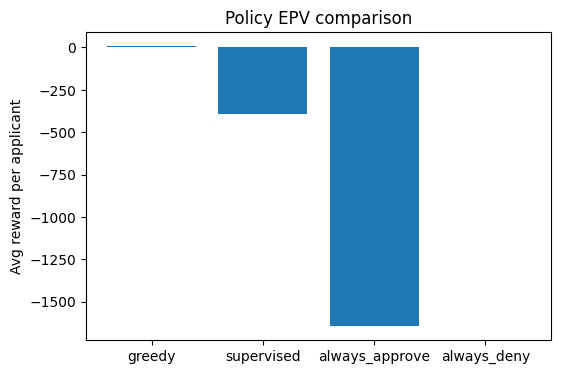

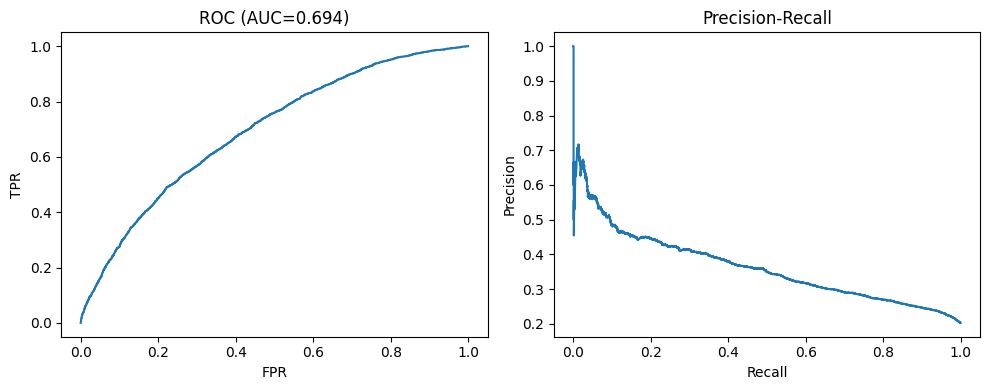

In [15]:

display_cols = ['index','greedy_action','supervised_action','p_default','loan_amnt','int_rate','true_default','exp_reward_if_approve','obs_reward_if_approve']
display(disagree_df[display_cols].head(10))


import numpy as np, pandas as pd
def policy_stats(actions, name):
    approved_idx = np.where(actions==1)[0]
    la = loan_test[approved_idx]
    ir = int_test[approved_idx]
    true = y_test[approved_idx]
    obs_rewards = np.array([observed_reward(1, la[i], ir[i], true[i]) for i in range(len(approved_idx))])
    print(f"\n{name} approves: {len(approved_idx)} | avg loan: {la.mean():.2f} | avg int: {ir.mean():.4f} | avg observed reward: {obs_rewards.mean():.2f}")
policy_stats(greedy_actions, "Greedy")
policy_stats(sup_actions, "Supervised")

import matplotlib.pyplot as plt
pols = ['greedy','supervised','always_approve','always_deny']
vals = [summary_df['avg_reward_per_applicant'][0],
        summary_df['avg_reward_per_applicant'][1],
        summary_df['avg_reward_per_applicant'][2],
        summary_df['avg_reward_per_applicant'][3]]
plt.figure(figsize=(6,4))
plt.bar(pols, vals)
plt.ylabel("Avg reward per applicant")
plt.title("Policy EPV comparison")
plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_test, probs_test)
pr, rc, _ = precision_recall_curve(y_test, probs_test)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC (AUC={auc(fpr,tpr):.3f})')
plt.subplot(1,2,2)
plt.plot(rc, pr); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
plt.tight_layout(); plt.show()
